In [5]:
import pandas as pd
import numpy as np
from os import path
from sklearn.linear_model import RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.gaussian_process.kernels import RBF
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    average_precision_score,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    accuracy_score
)
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import shap

In [6]:
data_file = "processed_ohe_True_selected_columns_95_zoonosis_dataset_full.csv"
one_hot_encoded = "True" in data_file

In [7]:
# X = pd.read_csv(
#     path.join("..", "cleaned_data", "x_significant_top_pcas.csv"), index_col=0
# )
# y = pd.read_csv(
#     path.join("..", "cleaned_data", "y_significant_top_pcas.csv"), index_col=0
# )

In [8]:
df = pd.read_csv(path.join("..", "cleaned_data", data_file))
df.drop_duplicates(inplace=True)
y = df["label"]
X = df.drop(columns=["label"])

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [10]:
def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(np.expm1(y_true), np.expm1(y_pred)))

In [11]:
models = [
    ("XGBoost", XGBClassifier(enable_categorical=True)),
    ("Random Forest", RandomForestClassifier()),
    ("Ridge Classifier", RidgeClassifier()),
    ("Decision Tree", DecisionTreeClassifier()),
    ("Support Vector Classification", SVC()),
    # ("LightGBM", LGBMClassifier()),
    ("KNN", KNeighborsClassifier(5, weights="uniform")),
    ("Naive Bayes", GaussianNB()),
    ("Neural Network", MLPClassifier()),
    ("Quadratic Discriminant Analysis", QuadraticDiscriminantAnalysis()),
]

In [12]:
min_error = float("inf")

for name, model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmsle_score = rmsle(y_test, y_pred)

    if rmsle_score < min_error:
        min_error = rmsle_score
        best_model = (name, model)

    print(f"{name}: RMSLE = {rmsle_score}")
print(best_model[0])

XGBoost: RMSLE = 0.09990802179250799
Random Forest: RMSLE = 0.10250346755876501
Ridge Classifier: RMSLE = 0.12554059619245156
Decision Tree: RMSLE = 0.12554059619245156
Support Vector Classification: RMSLE = 0.12343051992630368
KNN: RMSLE = 0.1146023606954215
Naive Bayes: RMSLE = 0.24579468048359396
Neural Network: RMSLE = 0.1111111111111111
Quadratic Discriminant Analysis: RMSLE = 0.23929675446098472
XGBoost


/Users/austinandrews/Projects/ukase_data_challenge/.venv/lib/python3.13/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/austinandrews/Projects/ukase_data_challenge/.venv/lib/python3.13/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
/Users/austinandrews/Projects/ukase_data_challenge/.venv/lib/python3.13/site-packages/sklearn/discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(


## Plot Model Performance

In [13]:
def get_feature_importance(model, X):
    try:
        mdi_importances = pd.Series(
            model.feature_importances_, index=X.columns
        ).sort_values(ascending=True)
        return mdi_importances
    except AttributeError:
        pass


def get_permutation_importance(model, X, y):
    result = permutation_importance(model, X, y, n_repeats=10, random_state=42)
    # Create a Series with feature names and their mean importances
    importances = pd.Series(result.importances_mean, index=X.columns)
    # Sort importances from most to least important
    sorted_importances = importances.sort_values(ascending=False)
    return sorted_importances

In [14]:
def get_results_all_models(models, X_train, X_test, y_train, y_test):
    results = {}
    for name, model in models:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        average_precision = average_precision_score(y_test, y_pred)
        feature_importance = get_feature_importance(model, X_test)
        permutation_importance = get_permutation_importance(model, X_test, y_test)
        try:
            most_important_feature = feature_importance.index[-1]
        except AttributeError:
            most_important_feature = None
        most_important_permutation = permutation_importance.index[0]
        results[name] = {
            "accuracy": accuracy,
            "roc_auc": roc_auc,
            "precision": precision,
            "recall": recall,
            "f1": f1,
            "average_precision": average_precision,
            "feature_importance": feature_importance,
            "most_important_feature": most_important_feature,
            "permutation_importance": permutation_importance,
            "most_important_permutation": most_important_permutation,
            "columns": ",".join(X_test.columns.to_list()),
        }
    return results

In [ ]:
results = get_results_all_models(models, X_train, X_test, y_train, y_test)

In [ ]:
def plot_model_results(results):

    names = []
    accuracies = []
    roc_auc_curves = []
    precisions = []
    recalls = []
    f1s = []
    average_precisions = []
    for name, result in results.items():
        names.append(name)
        accuracies.append(result["accuracy"])
        roc_auc_curves.append(result["roc_auc"])
        precisions.append(result["precision"])
        recalls.append(result["recall"])
        f1s.append(result["f1"])
        average_precisions.append(result["average_precision"])

    X_axis = np.arange(len(names))

    plt.bar(X_axis - 0.3, accuracies, 0.1, label="Accuracies")
    plt.bar(X_axis - 0.2, roc_auc_curves, 0.1, label="ROC AUC")
    plt.bar(X_axis - 0.1, precisions, 0.1, label="Precision")
    plt.bar(X_axis + 0.0, recalls, 0.1, label="Recall")
    plt.bar(X_axis + 0.1, f1s, 0.1, label="F1")
    plt.bar(X_axis + 0.2, average_precisions, 0.1, label="Avg Precision")

    plt.xticks(X_axis, names, rotation=90)
    plt.xlabel("Models")
    plt.ylabel("Score")
    plt.title("Metrics of Different Models")
    plt.legend()
    plt.show()

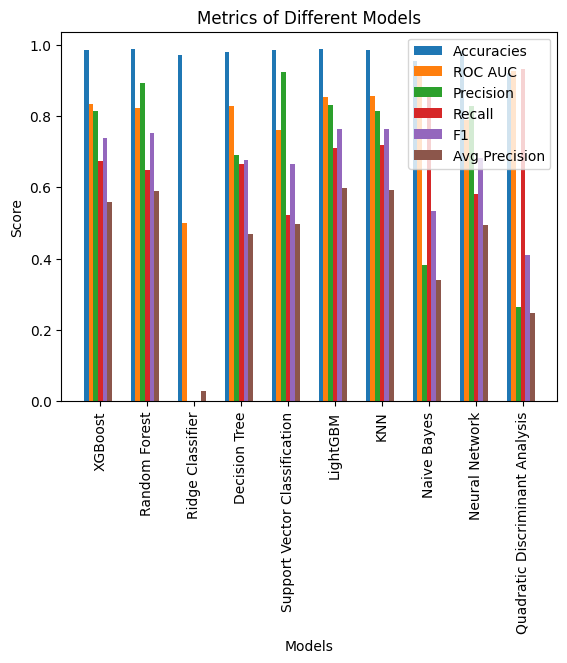

In [ ]:
plot_model_results(results)

In [ ]:
results_to_be_saved = pd.DataFrame.from_dict(data=results, orient="index")
results_to_be_saved.to_csv(path.join("..", "model_comparison_data", "annasselection_results.csv"))

## Feature importance of best performing algorthims

In [41]:
model = DecisionTreeClassifier()
model.fit(X_train, y_train)

DecisionTreeClassifier()

In [42]:
def plot_feature_importance(model, X):

    mdi_importances = pd.Series(
        model.feature_importances_, index=X.columns
    ).sort_values(ascending=True)
    ax = mdi_importances.plot.barh()
    ax.set_title("Decision Tree Feature Importances (MDI)")
    ax.figure.tight_layout()

In [43]:
def plot_permutation_importance(model, X, y):
    result = permutation_importance(
        model, X, y, n_repeats=10, random_state=42, n_jobs=2
    )

    sorted_importances_idx = result.importances_mean.argsort()
    importances = pd.DataFrame(
        result.importances[sorted_importances_idx].T,
        columns=X.columns[sorted_importances_idx],
    )
    ax = importances.plot.box(vert=False, whis=10)
    ax.set_title("Permutation Importances")
    ax.axvline(x=0, color="k", linestyle="--")
    ax.set_xlabel("Decrease in accuracy score")
    ax.figure.tight_layout()

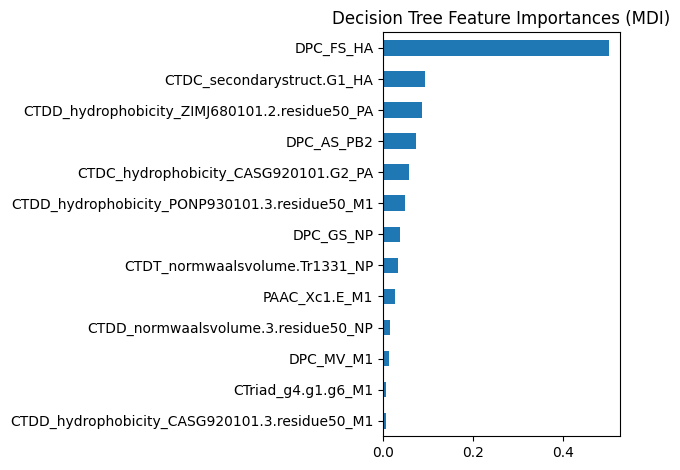

In [44]:
plot_feature_importance(model, X)

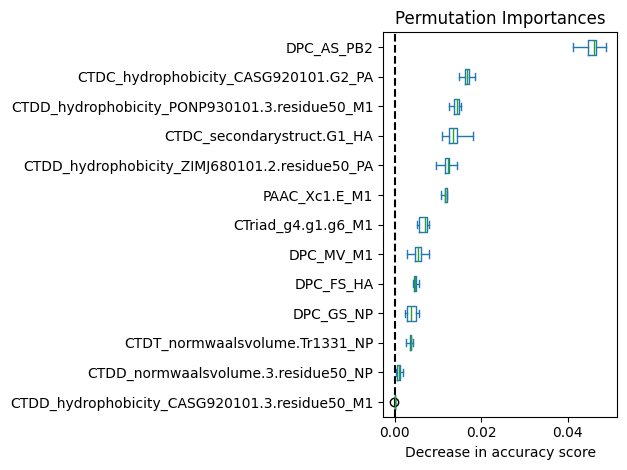

In [45]:
plot_permutation_importance(model, X_test, y_test)

## Shapley plots of best performing algorithms

In [93]:
def get_shap_values(model, X, sample_index=10, class_index=1):
    explainer = shap.Explainer(model, X)
    shap_values = explainer(X)
    shap_sample = shap_values[sample_index].values
    if shap_sample.ndim == 2:
        shap_sample = shap_sample[:, class_index]
    return pd.Series(shap_sample, index=X.columns)

In [135]:
# explainer = shap.Explainer(model, X_test)
# explanation = explainer(X)
# shap_values = explanation.values
# shap_values_mean = shap_values.mean(axis=0)
# shap_values_mean, X.columns
# indexed_shap_values = pd.Series(shap_values_mean, index=X.columns)
# indexed_shap_values
# shap_sample = shap_values.values
# shap_sample.values

explainer = shap.Explainer(model)
shap_values = explainer(X_test)
# shap_importance = (
#     pd.Series(shap_values.values.mean(axis=0), X.columns)
#     .abs()
#     .sort_values(ascending=False)
# )

pd.DataFrame(shap_values.values[0], index=X.columns)

,0,1
DPC_FS_HA,0.009247,-0.009247
CTDC_secondarystruct.G1_HA,0.005069,-0.005069
DPC_MV_M1,0.004277,-0.004277
CTDD_hydrophobicity_PONP930101.3.residue50_M1,0.008425,-0.008425
CTDD_hydrophobicity_CASG920101.3.residue50_M1,0.000153,-0.000153
CTriad_g4.g1.g6_M1,0.001769,-0.001769
PAAC_Xc1.E_M1,-0.001491,0.001491
DPC_GS_NP,-0.002482,0.002482
CTDD_normwaalsvolume.3.residue50_NP,-0.000699,0.000699
CTDT_normwaalsvolume.Tr1331_NP,0.000055,-0.000055


In [121]:
# results_to_be_saved["shap"]["Decision Tree"] = get_shap_values(model, X_test, y_test)
get_shap_values(model, X_test)

DPC_FS_HA                                        0.000000
CTDC_secondarystruct.G1_HA                      -0.010298
DPC_MV_M1                                       -0.016714
CTDD_hydrophobicity_PONP930101.3.residue50_M1   -0.003333
CTDD_hydrophobicity_CASG920101.3.residue50_M1    0.000000
CTriad_g4.g1.g6_M1                              -0.003333
PAAC_Xc1.E_M1                                    0.002619
DPC_GS_NP                                        0.002714
CTDD_normwaalsvolume.3.residue50_NP              0.000000
CTDT_normwaalsvolume.Tr1331_NP                  -0.004762
CTDC_hydrophobicity_CASG920101.G2_PA             0.006286
CTDD_hydrophobicity_ZIMJ680101.2.residue50_PA    0.002702
DPC_AS_PB2                                       0.001619
dtype: float64

In [136]:
def shapley_waterfall(model):
    explainer = shap.Explainer(model.predict, X_test)
    shap_values = explainer(X)
    shap.plots.waterfall(shap_values[0], max_display=14)


def shapley_beeswarm(model):
    explainer = shap.Explainer(model.predict, X_test)
    shap_values = explainer(X)
    shap.plots.beeswarm(shap_values)


def shapley_heatmap(model):
    explainer = shap.Explainer(model.predict, X_test)
    shap_values = explainer(X)
    shap.plots.heatmap(shap_values[:1000])

PermutationExplainer explainer: 19532it [09:13, 34.63it/s]                           


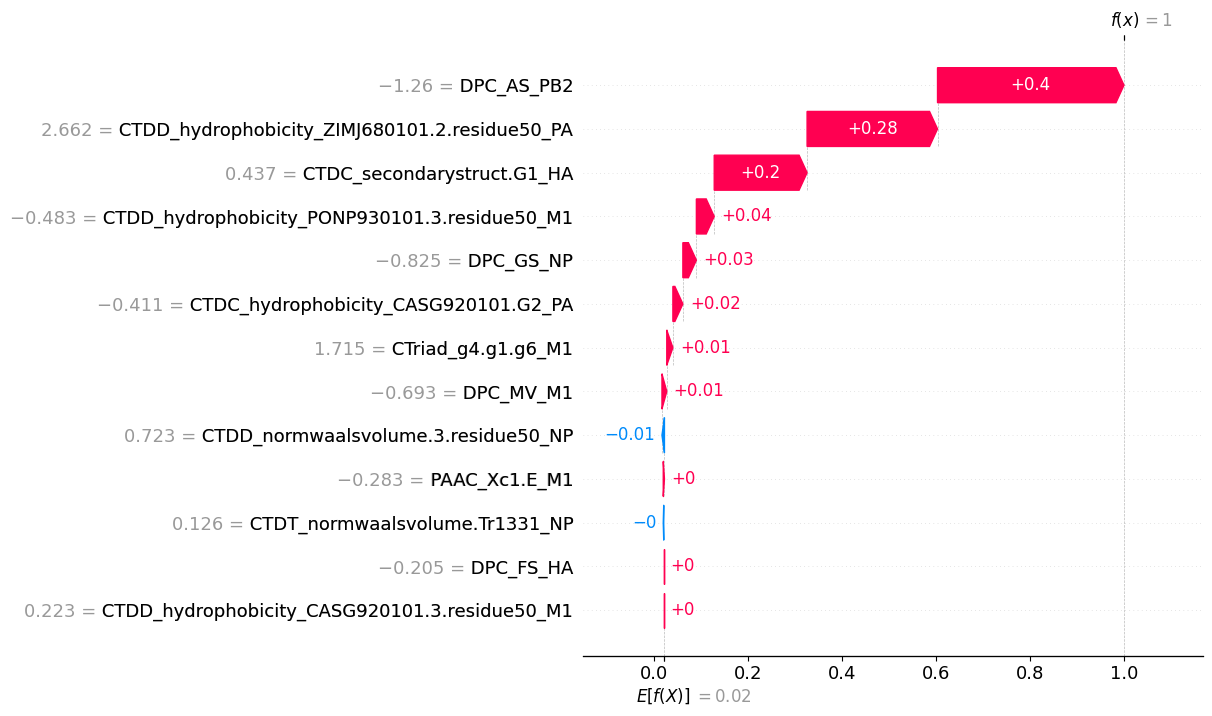

In [137]:
shapley_waterfall(model)

PermutationExplainer explainer: 19532it [08:54, 35.80it/s]                           


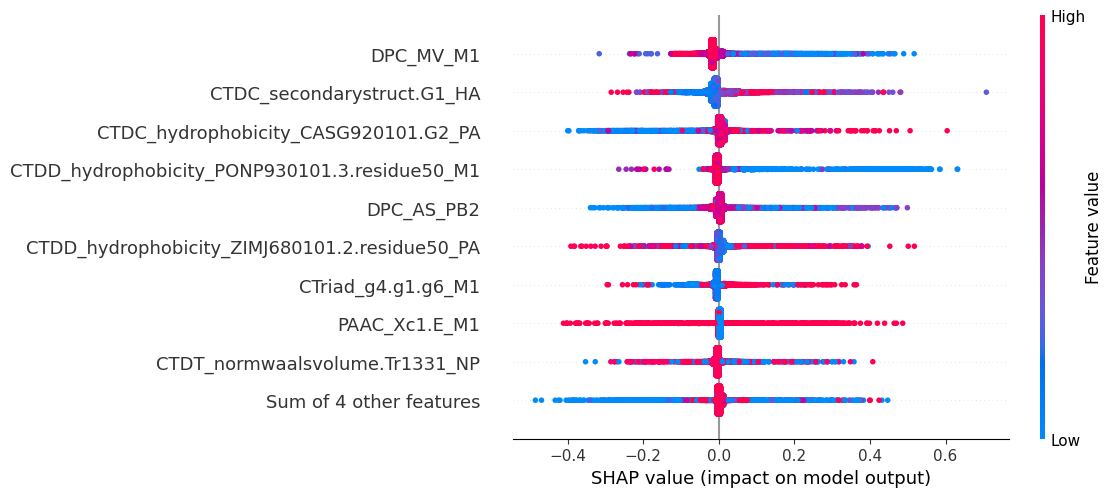

In [48]:
shapley_beeswarm(model)

PermutationExplainer explainer: 19532it [09:00, 35.43it/s]                           


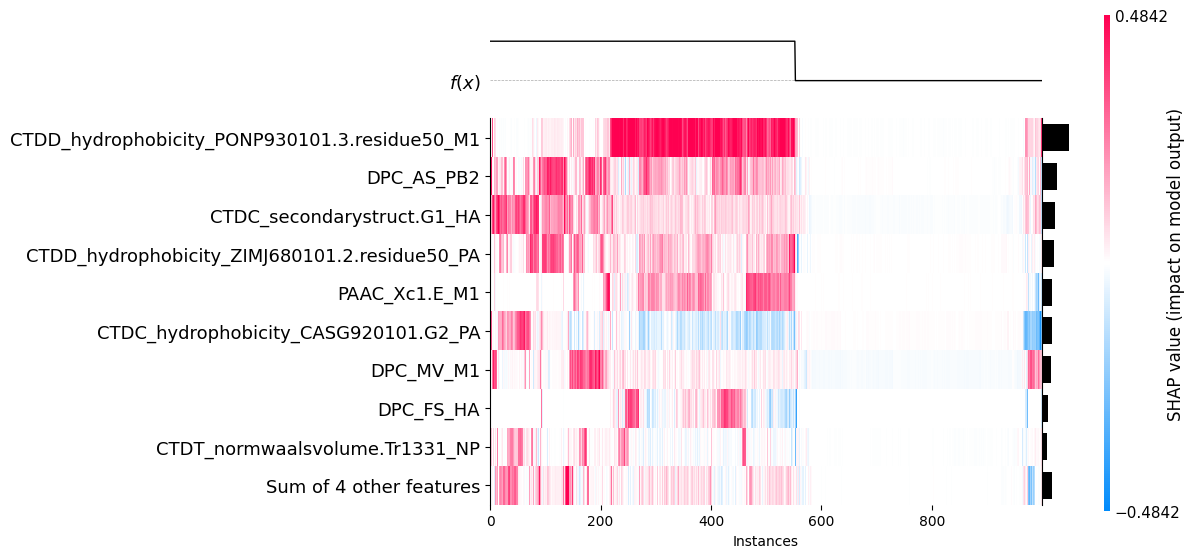

In [49]:
shapley_heatmap(model)